In [30]:
import numpy as np
import itertools
from itertools import combinations
from itertools import combinations, product
from itertools import permutations
import warnings
import time
from idQ import local_identifiability

from idQ import is_parallel
from idQ import is_strictly_less_than
from idQ import is_less_equal_than
from idQ import generate_binary_vectors
from idQ import generate_permutations
from idQ import get_D_l
from idQ import height_of_Q
from idQ import distances2U
from idQ import preserve_partial_order
import random
from expr_function import test_local_identifiability


In [31]:
Q = np.array([
    [0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1, 1],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 1, 0, 1, 0],
    [0, 0, 1, 0, 1, 1],
    [0, 0, 1, 1, 1, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 1, 0, 1, 1, 0],
    [0, 1, 0, 1, 1, 1],
    [0, 1, 1, 0, 0, 0],
    [0, 1, 1, 1, 1, 0],
    [1, 0, 0, 0, 1, 0],
    [1, 0, 1, 1, 0, 0],
    [1, 0, 1, 1, 0, 1],
    [1, 1, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 1, 0]
], dtype=np.int8)

In [32]:
local_identifiability(Q, kappa = 6, uniout=True, check_level=5)

('Q is 6-locally identifiable.', [])

In [ ]:
def generate_Q(J, K):
    # Generate all possible binary sequences of length K
    all_sequences = list(itertools.product([0, 1], repeat=K))

    # Remove the sequence of all zeros if it's present
    all_sequences = [seq for seq in all_sequences if any(seq)]

    # Randomly select J unique sequences
    selected_sequences = random.sample(all_sequences, J)

    # Convert the selected sequences into a NumPy array
    Q = np.array(selected_sequences)
    
    # Sort rows of Q
    Q = Q[np.lexsort(Q.T[::-1])]

    return Q

In [23]:
test_local_identifiability(7, 4, [6], [5, 6])

J: 7, K: 4
Q:
[[0 0 1 0]
 [0 1 0 0]
 [0 1 0 1]
 [0 1 1 0]
 [0 1 1 1]
 [1 0 0 1]
 [1 1 1 1]]
kappa: 6, check_level: 5
Q is kappa-locally identifiable because you can't replace kappa many of the rows.
Q is kappa-locally identifiable because you can't replace kappa many of the rows.
Runtime: 0.00022125244140625 seconds
---------------------------
kappa: 6, check_level: 6
Q is kappa-locally identifiable because you can't replace kappa many of the rows.
Q is kappa-locally identifiable because you can't replace kappa many of the rows.
Runtime: 0.000225067138671875 seconds
---------------------------


In [3]:
Q = np.array([[1, 0, 0, 0, 1],
     [0, 1, 0, 0, 1],
     [0, 0, 1, 0, 1],
     [0, 0, 0, 1, 1]])
distances2U(Q)

[3, 3, 3, 3]

In [4]:
Q = np.array([[1, 0, 0, 1],
     [0, 1, 0, 1],
     [0, 0, 1, 1]])
distances2U(Q)

[2, 2, 2]

In [165]:
Q

array([[1, 0, 0, 1],
       [0, 1, 0, 1],
       [0, 0, 1, 1]])

In [5]:
Q = np.array([[1, 0, 0, 1],
       [0, 1, 0, 1],
       [0, 0, 1, 1]])

In [487]:
def local_identifiability(Q, kappa, uniout=False, check_level=1):
    # Check if Q is valid
    if not isinstance(Q, np.ndarray) or not np.all((Q == 0) | (Q == 1)):
        raise Exception("Q must be a binary matrix.")
    
    result, message, Q_bar = check_necessary(Q)

    
    if not result:
        print(message)
        return Q_bar
    
    # Get the number of rows (J) and columns (K) of Q
    J, K = Q.shape
    
    # Find out which rows are irreplaceable (having exactly one 1 or all 1)
    irreplaceable_rows = np.where(np.sum(Q, axis=1) == 1)[0]
    
    # Find out which rows are replaceable
    replaceable_rows = set(range(J)) - set(irreplaceable_rows)
    
    if kappa > len(replaceable_rows):
        print("Q is kappa-locally identifiable because you can't replace kappa many of the rows.")
        return True
    
    # Calculate the distance to the universal set (d(Q[j,])) for each replaceable row
    distances = distances2U(Q)
    
    # Prepare the list to hold all possible Q_bar matrices
    Q_bars = []
    
    # Iterate through all possible replacements of exactly kappa rows
    for replacement_indices in combinations(replaceable_rows, kappa):
        subQ_bars = []
        for i in range(kappa):
            index = replacement_indices[i]
            # Generate all possible replacements for the current set of rows,
            # binary vectors with at most K - distances[index] ones
            q_bars = []
            for p in range(1, K - distances[index] + 1):
                q_bars.extend(generate_binary_vectors(K, p))

            # Filter out the original row from q_bars
            q_bars = [q_bar for q_bar in q_bars if not np.array_equal(q_bar, Q[index])]

            # Filter out the rows that do not preserve the partial order
            Q_temp = Q.copy()
            valid_q_bars = []  # We will store the valid q_bars here

            # Iterate over all q_bars
            for q_bar in q_bars:
                Q_temp[index, :] = q_bar  # Replace the row in Q_temp
                
                fixed_rows = (set(replaceable_rows) - set(replacement_indices)) | set(irreplaceable_rows)
                # Check if the order is preserved after replacement
                if preserve_partial_order(Q, Q_temp, fixed_rows, [index]):
                    valid_q_bars.append(q_bar)  # If the order is preserved, keep this q_bar

            q_bars = valid_q_bars  # Replace the original q_bars with the valid ones

            subQ_bars.append(q_bars)

        # Generate Cartesian product of subQ_bars
        subQ_bars = list(product(*subQ_bars))

        # After obtaining subQ_bars from the cartesian product
        for subQ_bar_replacements in subQ_bars:
            Q_bar = Q.copy()
            Q_bar[replacement_indices, :] = np.array(subQ_bar_replacements)  # Replace the rows in Q with subQ_bar_replacements

            # Check for preservation of partial order exactly among the rows specified by replacement_indices
            if preserve_partial_order(Q, Q_bar, replacement_indices, replacement_indices):
                Q_bars.append(Q_bar)  # If the partial order is preserved, add this Q_bar to the list

    # Now, Q_bars is a list of all possible Q_bar matrices that satisfy the conditions
    
    # Generate all permutations of Q
    Q_perms = generate_permutations(Q)

    
    # Filter out Q_bars that match a permutation of Q
    Q_bars = [Q_bar for Q_bar in Q_bars if not any(np.array_equal(Q_perm, Q_bar) for Q_perm in Q_perms)]
 
    if uniout:
        Q_bars_uniq = []
        seen = set()

        for Q_bar in Q_bars:
            # Generate all unique column permutations for each Q_bar
            perms_indices = list(itertools.permutations(range(Q_bar.shape[1])))

            # Rearrange columns according to the permutations, then convert to bytes
            perms_bytes = [Q_bar[:, p].tobytes() for p in perms_indices]

            # Check if the permutation has been seen before
            found = False
            for perm in perms_bytes:
                if perm in seen:
                    found = True
                    break
                seen.add(perm)
            if not found:
                Q_bars_uniq.append(Q_bar)

        Q_bars = Q_bars_uniq

    
    # Check if Q_bars is empty
    if not Q_bars:
        return f"Q is {kappa}-locally identifiable."
    
    if check_level == 1:
        return Q_bars
    
    if check_level > 1:
        if check_level >= J:
            warnings.warn("Check level is larger than J.")
        filtered_Q_bars = []
        for Q_bar in Q_bars:
            preserve_order = True
            for l in range(2, check_level + 1):
                D_l_Q = get_D_l(Q, l)
                D_l_Q_bar = get_D_l(Q_bar, l)

                JJ = D_l_Q.shape[0]
                if not preserve_partial_order(D_l_Q, D_l_Q_bar, range(JJ), range(JJ)):
                    preserve_order = False
                    break
            if preserve_order:
                filtered_Q_bars.append(Q_bar)
                
    return filtered_Q_bars


In [476]:
Q1 = np.array([[1, 0, 0], [0, 0, 1], [1, 0, 1]])
result, message, Q_bar = check_necessary(Q1)
local_identifiability(Q1, 3, uniout=True)

Q is not identifiable. Q contains a zero column.


array([[1, 1, 0],
       [0, 1, 1],
       [1, 1, 1]])

In [488]:
Q4 = np.array([[1, 1, 0], [0, 1, 1], [1, 0, 1]])
local_identifiability(Q4, 3, uniout=True, check_level = 1)

[array([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]])]

In [477]:
Q1 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
print(local_identifiability(Q1, 1))

Q is kappa-locally identifiable because you can't replace kappa many of the rows.
True


In [465]:
Q2 = np.array([[1, 1, 0], [1, 0, 1], [0, 1, 1]])
local_identifiability(Q2, 2)

'Q is 2-locally identifiable.'

In [23]:
Q2

array([[1, 1, 0],
       [1, 0, 1],
       [0, 1, 1]])

In [330]:
Q3 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 1]])
print(distances2U(Q2))  # Expected output: [1, 1, 1, 1]

[1, 1, 1]


In [331]:
Q1 = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
print(distances2U(Q1))  # Expected output: [2, 2, 2]


[2, 2, 2]


In [332]:
Q52 = np.array(generate_binary_vectors(5,2))
Q52

array([[1, 1, 0, 0, 0],
       [1, 0, 1, 0, 0],
       [1, 0, 0, 1, 0],
       [1, 0, 0, 0, 1],
       [0, 1, 1, 0, 0],
       [0, 1, 0, 1, 0],
       [0, 1, 0, 0, 1],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 0, 1],
       [0, 0, 0, 1, 1]])

In [490]:
local_identifiability(np.eye(4), 4)

Q is kappa-locally identifiable because you can't replace kappa many of the rows.


True

In [493]:
def prop_check(K):
    I_K = np.array(generate_binary_vectors(K, 1))
    Q = I_K.copy()
    Q[K-1, :] = I_K[K-1, :] + I_K[K-2, :]
    Q = np.concatenate((Q, I_K[K-1, :][None, :] + I_K[K-3, :][None, :]), axis=0)
    return local_identifiability(Q, 1), local_identifiability(Q, 2)


('Q is 1-locally identifiable.', 'Q is 2-locally identifiable.')

In [ ]:
prop_check(9)

In [279]:
def generate_Q(J, K):
    # Generate all possible binary sequences of length K
    all_sequences = list(itertools.product([0, 1], repeat=K))

    # Remove the sequence of all zeros if it's present
    all_sequences = [seq for seq in all_sequences if any(seq)]

    # Randomly select J unique sequences
    selected_sequences = random.sample(all_sequences, J)

    # Convert the selected sequences into a NumPy array
    Q = np.array(selected_sequences)

    return Q

In [499]:
J = 12
K = 7

In [400]:
def compare_height_functions(J, K):
    Q = generate_Q(J, K)

    start_time = time.time()
    height1 = height_of_Q(Q)
    end_time = time.time()
    runtime1 = end_time - start_time

    start_time = time.time()
    height2 = height_v2(Q)
    end_time = time.time()
    runtime2 = end_time - start_time

    return height1 == height2, runtime1 - runtime2

In [500]:
QQ1 = generate_Q(J, K)
QQ1

array([[1, 0, 1, 1, 1, 1, 1],
       [0, 0, 1, 0, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [1, 1, 0, 1, 1, 1, 1],
       [0, 0, 0, 1, 0, 1, 1],
       [1, 0, 1, 0, 1, 1, 1],
       [1, 1, 1, 0, 1, 1, 0],
       [0, 0, 1, 0, 0, 1, 0],
       [0, 1, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [1, 1, 1, 0, 0, 1, 0]])

In [502]:
local_identifiability(QQ1, 1, check_level = 2)

[array([[1, 0, 1, 1, 1, 0, 1],
        [0, 0, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0],
        [0, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 1, 0, 1, 1],
        [1, 0, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0],
        [0, 0, 1, 0, 0, 1, 0],
        [0, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0]]),
 array([[1, 0, 1, 1, 1, 1, 1],
        [0, 0, 1, 0, 1, 0, 1],
        [0, 1, 1, 1, 1, 0, 0],
        [0, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 1, 0, 1, 1],
        [1, 0, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0],
        [0, 0, 1, 0, 0, 1, 0],
        [0, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0]]),
 array([[1, 0, 1, 1, 1, 1, 1],
        [0, 0, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 0, 0],
        [0, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 1, 0, 1, 1],
        [1, 0, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0],
    

In [503]:
local_identifiability(QQ1, 1, check_level = 3)

[array([[1, 0, 1, 1, 1, 0, 1],
        [0, 0, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0],
        [0, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 1, 0, 1, 1],
        [1, 0, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0],
        [0, 0, 1, 0, 0, 1, 0],
        [0, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0]]),
 array([[1, 0, 1, 1, 1, 1, 1],
        [0, 0, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 0, 0],
        [0, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 1, 0, 1, 1],
        [1, 0, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0],
        [0, 0, 1, 0, 0, 1, 0],
        [0, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0]]),
 array([[1, 0, 1, 1, 1, 1, 1],
        [0, 0, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0],
        [0, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 1, 1, 0, 1],
        [0, 0, 0, 1, 0, 1, 1],
        [1, 0, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0],
    

In [504]:
local_identifiability(QQ1, 1, check_level = 4)

[array([[1, 0, 1, 1, 1, 0, 1],
        [0, 0, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0],
        [0, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 1, 0, 1, 1],
        [1, 0, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0],
        [0, 0, 1, 0, 0, 1, 0],
        [0, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0]]),
 array([[1, 0, 1, 1, 1, 1, 1],
        [0, 0, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 0, 0],
        [0, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 1, 1, 1, 1],
        [0, 0, 0, 1, 0, 1, 1],
        [1, 0, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0],
        [0, 0, 1, 0, 0, 1, 0],
        [0, 1, 1, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [1, 1, 1, 0, 0, 1, 0]]),
 array([[1, 0, 1, 1, 1, 1, 1],
        [0, 0, 1, 0, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0],
        [0, 0, 1, 0, 1, 0, 0],
        [1, 1, 0, 1, 1, 0, 1],
        [0, 0, 0, 1, 0, 1, 1],
        [1, 0, 1, 0, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0],
    

In [157]:
np.array(generate_binary_vectors(5, 2))

array([[1, 1, 0, 0, 0],
       [1, 0, 1, 0, 0],
       [1, 0, 0, 1, 0],
       [1, 0, 0, 0, 1],
       [0, 1, 1, 0, 0],
       [0, 1, 0, 1, 0],
       [0, 1, 0, 0, 1],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 0, 1],
       [0, 0, 0, 1, 1]])

In [241]:
local_identifiability(np.array(generate_binary_vectors(5, 2)), 1)

'Q is 1-locally identifiable.'

In [242]:
local_identifiability(generate_Q(J, K), 1)

'Q is 1-locally identifiable.'

In [62]:
QQ1

array([[1, 0, 0, 0, 1],
       [1, 1, 0, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0],
       [0, 0, 0, 1, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 1],
       [1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1]])

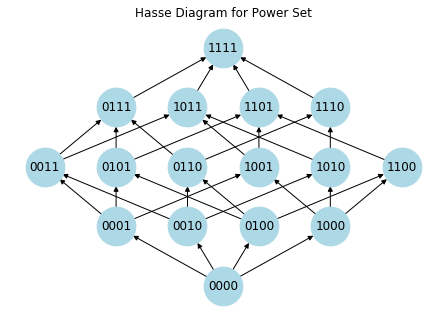

In [53]:
import matplotlib.pyplot as plt
import networkx as nx

# Define node positions (copied from your LaTeX diagram)
positions = {
    '0000': (5.5, 0),
    '0001': (4, 1),
    '0010': (5, 1),
    '0100': (6, 1),
    '1000': (7, 1),
    '0011': (3, 2),
    '0101': (4, 2),
    '0110': (5, 2),
    '1001': (6, 2),
    '1010': (7, 2),
    '1100': (8, 2),
    '0111': (4, 3),
    '1011': (5, 3),
    '1101': (6, 3),
    '1110': (7, 3),
    '1111': (5.5, 4)
}

# Create graph
G = nx.DiGraph()

# Add nodes to the graph
for node in positions.keys():
    G.add_node(node)

# Define edges (manually from your LaTeX diagram)
edges = [
    ('0000', '0001'),
    ('0000', '0010'),
    ('0000', '0100'),
    ('0000', '1000'),
    ('0001', '0011'),
    ('0010', '0011'),
    ('0001', '0101'),
    ('0100', '0101'),
    ('0001', '1001'),
    ('1000', '1001'),
    ('0010', '0110'),
    ('0100', '0110'),
    ('1000', '1010'),
    ('0010', '1010'),
    ('0100', '1100'),
    ('1000', '1100'),
    ('0011', '0111'),
    ('0101', '0111'),
    ('0011', '1011'),
    ('1001', '1011'),
    ('0101', '1101'),
    ('1001', '1101'),
    ('1100', '1101'),
    ('1010', '1011'),
    ('0110', '0111'),
    ('1010', '1110'),
    ('0110', '1110'),
    ('0001', '0011'),
    ('0011', '0111'),
    ('0111', '1111'),
    ('1001', '1011'),
    ('1011', '1111'),
    ('1101', '1111'),
    ('1110', '1111')
]

# Add edges to the graph
G.add_edges_from(edges)

# Draw the graph
nx.draw(G, pos=positions, with_labels=True, node_color='lightblue', node_size=1500)
plt.title('Hasse Diagram for Power Set')
plt.show()

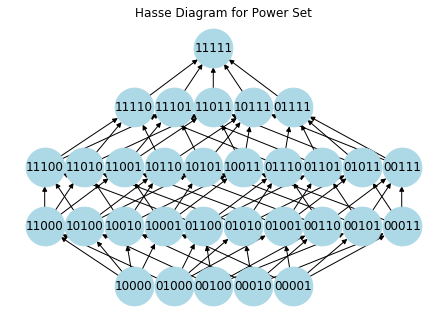

In [54]:
    import matplotlib.pyplot as plt
    import networkx as nx

    # Define node positions (copied from your LaTeX diagram)
    positions = {
        '10000': (6.5,2), '01000': (8.5,2), '00100': (10.5,2), '00010': (12.5,2), '00001': (14.5,2),
        '11000': (2,4), '10100': (4,4), '10010': (6,4), '10001': (8,4), '01100': (10,4), '01010': (12,4), '01001': (14,4), '00110': (16,4), '00101': (18,4), '00011': (20,4),
        '11100': (2,6), '11010': (4,6), '11001': (6,6), '10110': (8,6), '10101': (10,6), '10011': (12,6), '01110': (14,6), '01101': (16,6), '01011': (18,6), '00111': (20,6),
        '11110': (6.5,8), '11101': (8.5,8), '11011': (10.5,8), '10111': (12.5,8), '01111': (14.5,8),
        '11111': (10.5,10)
    }

    # Create graph
    G = nx.DiGraph()

    # Add nodes to the graph
    for node in positions.keys():
        G.add_node(node)

    # Define edges (manually from your LaTeX diagram)
    edges = [
        ('10000', '11000'), ('10000', '10100'), ('10000', '10010'), ('10000', '10001'),
        ('01000', '11000'), ('01000', '01100'), ('01000', '01010'), ('01000', '01001'),
        ('00100', '10100'), ('00100', '01100'), ('00100', '00110'), ('00100', '00101'),
        ('00010', '10010'), ('00010', '01010'), ('00010', '00110'), ('00010', '00011'),
        ('00001', '10001'), ('00001', '01001'), ('00001', '00101'), ('00001', '00011'),
        ('11000', '11100'), ('11000', '11010'), ('11000', '11001'),
        ('10100', '11100'), ('10100', '10110'), ('10100', '10101'),
        ('10010', '11010'), ('10010', '10110'), ('10010', '10011'),
        ('10001', '11001'), ('10001', '10101'), ('10001', '10011'),
        ('01100', '11100'), ('01100', '01110'), ('01100', '01101'),
        ('01010', '11010'), ('01010', '01110'), ('01010', '01011'),
        ('01001', '11001'), ('01001', '01101'), ('01001', '01011'),
        ('00110', '10110'), ('00110', '01110'), ('00110', '00111'),
        ('00101', '10101'), ('00101', '01101'), ('00101', '00111'),
        ('00011', '10011'), ('00011', '01011'), ('00011', '00111'),
        ('11100', '11110'), ('11100', '11101'),
        ('11010', '11110'), ('11010', '11011'),
        ('11001', '11101'), ('11001', '11011'),
        ('10110', '11110'), ('10110', '10111'),
        ('10101', '11101'), ('10101', '10111'),
        ('10011', '11011'), ('10011', '10111'),
        ('01110', '11110'), ('01110', '01111'),
        ('01101', '11101'), ('01101', '01111'),
        ('01011', '11011'), ('01011', '01111'),
        ('00111', '10111'), ('00111', '01111'),
        ('11110', '11111'),
        ('11101', '11111'),
        ('11011', '11111'),
        ('10111', '11111'),
        ('01111', '11111')
    ]

    # Add edges to the graph
    G.add_edges_from(edges)

    # Draw the graph
    nx.draw(G, pos=positions, with_labels=True, node_color='lightblue', node_size=1500)
    plt.title('Hasse Diagram for Power Set')
    plt.show()


In [239]:
generate_Q(10, 5)

array([[0, 1, 0, 0, 0],
       [0, 1, 1, 1, 1],
       [1, 1, 0, 0, 1],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 1],
       [1, 1, 0, 1, 1],
       [1, 1, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 0, 0, 0, 1]])

In [58]:
def generate_Q(J, K):
    Q = np.random.randint(2, size=(J, K))
    
    G = nx.DiGraph()
    colors = []
    for i, row in enumerate(Q):
        node = ''.join(map(str, row))
        G.add_node(node)
        colors.append(i)  # Add row index to color list
    
    # Continue with the rest of your code to add edges, etc.
    # ...

    # Define node positions (copied from your LaTeX diagram)
    positions = {
        '10000': (6.5,2), '01000': (8.5,2), '00100': (10.5,2), '00010': (12.5,2), '00001': (14.5,2),
        '11000': (2,4), '10100': (4,4), '10010': (6,4), '10001': (8,4), '01100': (10,4), '01010': (12,4), '01001': (14,4), '00110': (16,4), '00101': (18,4), '00011': (20,4),
        '11100': (2,6), '11010': (4,6), '11001': (6,6), '10110': (8,6), '10101': (10,6), '10011': (12,6), '01110': (14,6), '01101': (16,6), '01011': (18,6), '00111': (20,6),
        '11110': (6.5,8), '11101': (8.5,8), '11011': (10.5,8), '10111': (12.5,8), '01111': (14.5,8),
        '11111': (10.5,10)
    }

    # Create graph
    G = nx.DiGraph()

    # Add nodes to the graph
    for node in positions.keys():
        G.add_node(node)

    # Define edges (manually from your LaTeX diagram)
    edges = [
        ('10000', '11000'), ('10000', '10100'), ('10000', '10010'), ('10000', '10001'),
        ('01000', '11000'), ('01000', '01100'), ('01000', '01010'), ('01000', '01001'),
        ('00100', '10100'), ('00100', '01100'), ('00100', '00110'), ('00100', '00101'),
        ('00010', '10010'), ('00010', '01010'), ('00010', '00110'), ('00010', '00011'),
        ('00001', '10001'), ('00001', '01001'), ('00001', '00101'), ('00001', '00011'),
        ('11000', '11100'), ('11000', '11010'), ('11000', '11001'),
        ('10100', '11100'), ('10100', '10110'), ('10100', '10101'),
        ('10010', '11010'), ('10010', '10110'), ('10010', '10011'),
        ('10001', '11001'), ('10001', '10101'), ('10001', '10011'),
        ('01100', '11100'), ('01100', '01110'), ('01100', '01101'),
        ('01010', '11010'), ('01010', '01110'), ('01010', '01011'),
        ('01001', '11001'), ('01001', '01101'), ('01001', '01011'),
        ('00110', '10110'), ('00110', '01110'), ('00110', '00111'),
        ('00101', '10101'), ('00101', '01101'), ('00101', '00111'),
        ('00011', '10011'), ('00011', '01011'), ('00011', '00111'),
        ('11100', '11110'), ('11100', '11101'),
        ('11010', '11110'), ('11010', '11011'),
        ('11001', '11101'), ('11001', '11011'),
        ('10110', '11110'), ('10110', '10111'),
        ('10101', '11101'), ('10101', '10111'),
        ('10011', '11011'), ('10011', '10111'),
        ('01110', '11110'), ('01110', '01111'),
        ('01101', '11101'), ('01101', '01111'),
        ('01011', '11011'), ('01011', '01111'),
        ('00111', '10111'), ('00111', '01111'),
        ('11110', '11111'),
        ('11101', '11111'),
        ('11011', '11111'),
        ('10111', '11111'),
        ('01111', '11111')
    ]

    # Add edges to the graph
    G.add_edges_from(edges)

    # Draw the graph
    nx.draw(G, pos=positions, with_labels=True, node_color='lightblue', node_size=1500)
    plt.title('Hasse Diagram for Power Set')
    plt.show()
    
    nx.draw(G, node_color=colors, with_labels=True)
    plt.show()


In [34]:
import math

In [36]:
np.choose(4,3)

TypeError: 'int' object is not iterable